C:\Users\neilc\AppData\Local\Temp\ipykernel_4868\1599375057.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=corr_df, x='correlation', y='feature', size=10, orient='h', palette='coolwarm')


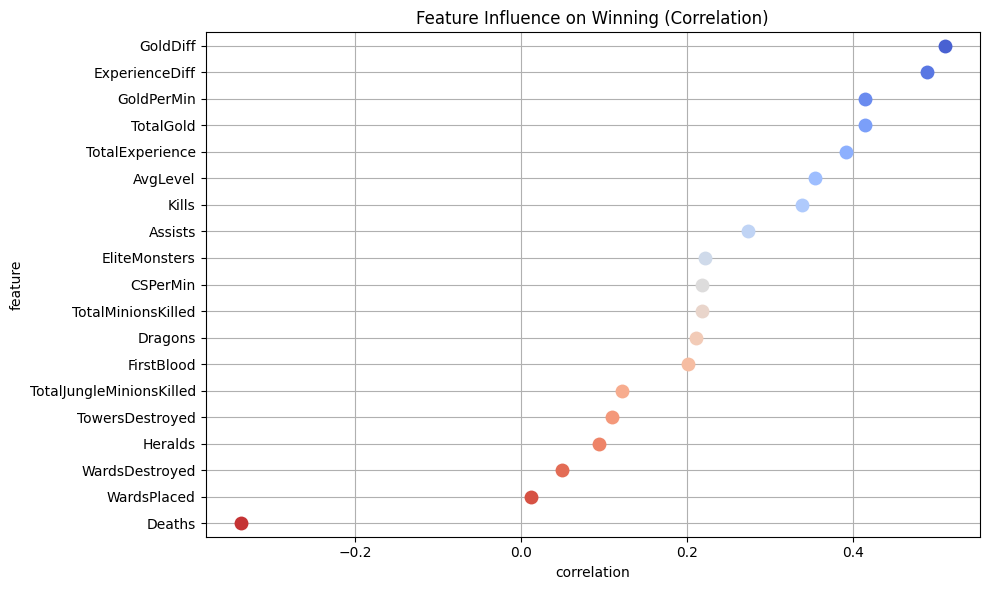

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load your dataset
df = pd.read_csv("team_data_with_win_label.csv")

# Compute correlations between numeric features and 'won'
numeric_features = df.select_dtypes(include='number').drop(columns=['won'])
correlations = numeric_features.corrwith(df['won'])

# Format data into a DataFrame
corr_df = correlations.reset_index()
corr_df.columns = ['feature', 'correlation']
corr_df = corr_df.sort_values(by='correlation', ascending=False)

# Save correlations as a JSON file
with open("correlation_importance.json", "w") as f:
    json.dump(corr_df.to_dict(orient="records"), f, indent=2)

# Plot the beeswarm plot (stripplot)
plt.figure(figsize=(10, 6))
sns.stripplot(data=corr_df, x='correlation', y='feature', size=10, orient='h', palette='coolwarm')
plt.title("Feature Influence on Winning (Correlation)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
%pip install shap
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:15:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 99%|===================| 19495/19758 [00:41<00:00]        

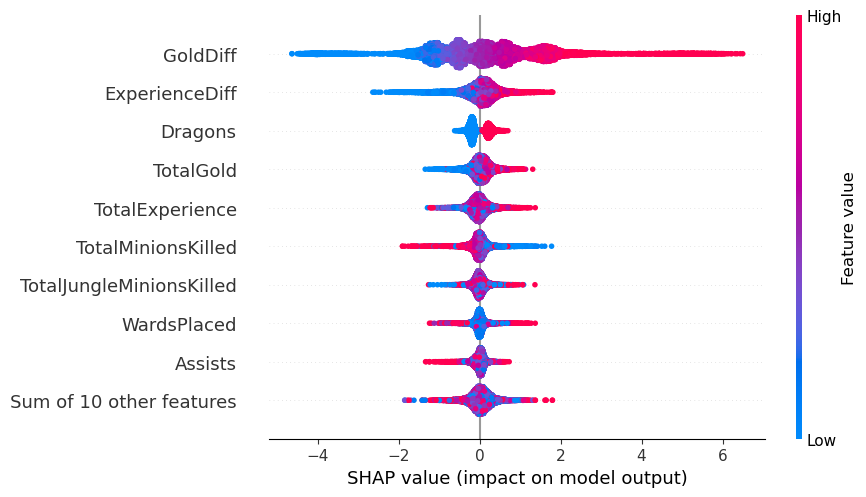

In [4]:
import pandas as pd
import shap
import xgboost
import matplotlib.pyplot as plt
import numpy as np
import json

# Load the data
df = pd.read_csv("team_data_with_win_label.csv")

# Drop non-numeric features (e.g. 'team')
X = df.drop(columns=["won"])
X = X.select_dtypes(include=["number", "bool"])
y = df["won"]

# Train an XGBoost model
model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# Explain predictions with SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot SHAP values (beeswarm)
shap.plots.beeswarm(shap_values)

# Save mean absolute SHAP values as JSON
mean_abs_shap = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

with open("shap_feature_importance.json", "w") as f:
    json.dump(mean_abs_shap.to_dict(orient="records"), f, indent=2)


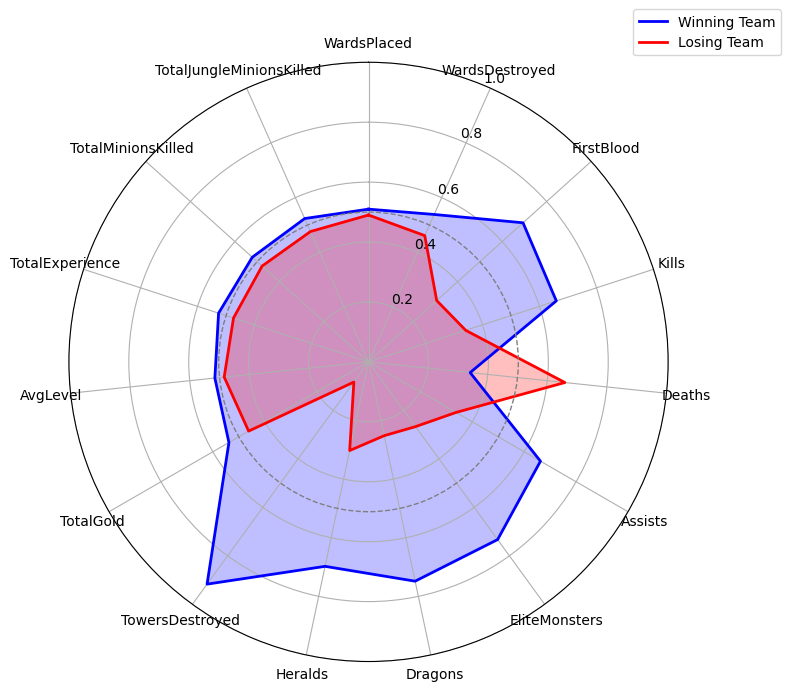

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load dataset
df = pd.read_csv("team_data_with_win_label.csv")

# Define the 10 features
top_features = [
"WardsPlaced", "WardsDestroyed", "FirstBlood", "Kills", "Deaths", "Assists", "EliteMonsters", "Dragons", "Heralds", "TowersDestroyed", "TotalGold", "AvgLevel", "TotalExperience", "TotalMinionsKilled", "TotalJungleMinionsKilled"
]

# Compute mean values
mean_win = df[df["won"] == 1][top_features].mean()
mean_lose = df[df["won"] == 0][top_features].mean()

# Normalize with X² / (X² + Y²)
normalized_win = []
normalized_lose = []

for feature in top_features:
    x = mean_win[feature]
    y = mean_lose[feature]
    denom = x**2 + y**2
    if denom == 0:
        normalized_win.append(0.1)
        normalized_lose.append(0.1)
    else:
        normalized_win.append(x**2 / denom)
        normalized_lose.append(y**2 / denom)

# Save to JSON
radar_data = {
    "labels": top_features,
    "winning_team": normalized_win,
    "losing_team": normalized_lose
}
with open("radar_x2_norm.json", "w") as f:
    json.dump(radar_data, f, indent=2)

# Radar chart
angles = np.linspace(0, 2 * np.pi, len(top_features), endpoint=False).tolist()
angles += angles[:1]
plot_win = normalized_win + normalized_win[:1]
plot_lose = normalized_lose + normalized_lose[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, plot_win, color='blue', linewidth=2, label='Winning Team')
ax.fill(angles, plot_win, color='blue', alpha=0.25)
ax.plot(angles, plot_lose, color='red', linewidth=2, label='Losing Team')
ax.fill(angles, plot_lose, color='red', alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), top_features)
ax.set_ylim(0, 1)
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# Sauvegarde aussi les vraies moyennes
raw_data = {
    "labels": top_features,
    "winning_team": mean_win.tolist(),
    "losing_team": mean_lose.tolist()
}
with open("radar_raw.json", "w") as f:
    json.dump(raw_data, f, indent=2)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

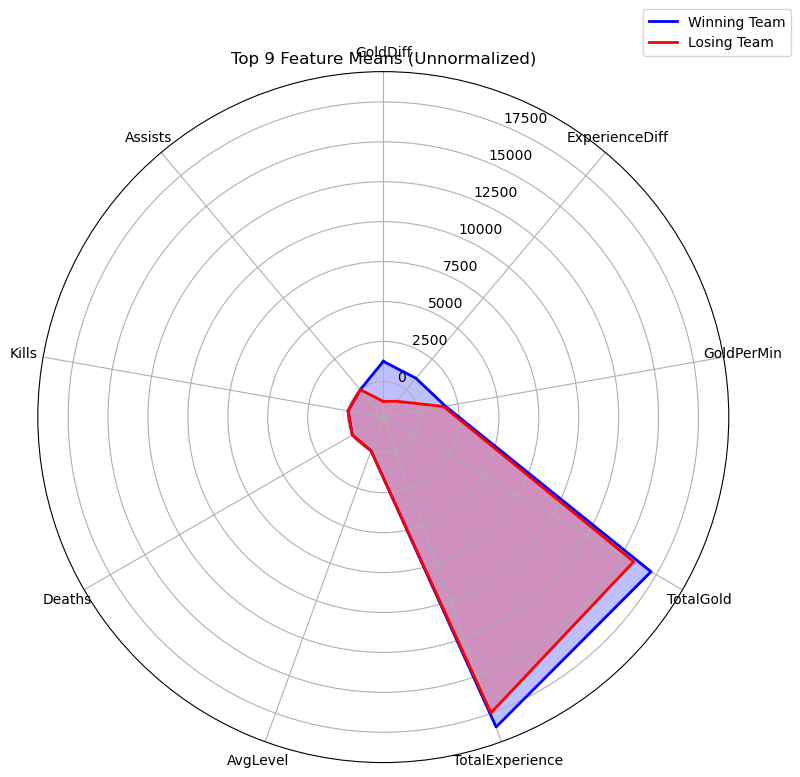

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load data
df = pd.read_csv("team_data_with_win_label.csv")

# Pick numeric features (exclude label)
numeric = df.select_dtypes(include=["number"]).drop(columns=["won"])

# Get top 9 most correlated features with 'won'
top_features = numeric.corrwith(df["won"]).abs().sort_values(ascending=False).head(9).index.tolist()

# Compute means
mean_win = df[df["won"] == 1][top_features].mean()
mean_lose = df[df["won"] == 0][top_features].mean()

# To lists for radar
labels = top_features
values_win = mean_win.tolist()
values_lose = mean_lose.tolist()

# Save to JSON
radar_data = {
    "labels": labels,
    "winning_team": values_win,
    "losing_team": values_lose
}
with open("shap_top9_radar_data.json", "w") as f:
    json.dump(radar_data, f, indent=2)

# Radar plot
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
values_win += values_win[:1]
values_lose += values_lose[:1]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values_win, color='blue', linewidth=2, label='Winning Team')
ax.fill(angles, values_win, color='blue', alpha=0.25)
ax.plot(angles, values_lose, color='red', linewidth=2, label='Losing Team')
ax.fill(angles, values_lose, color='red', alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title("Top 9 Feature Means (Unnormalized)")
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from dowhy import CausalModel

# Chargement des données
df = pd.read_csv("team_data_with_win_label.csv")

# Variables numériques uniquement (on enlève la colonne 'team' qui est catégorielle)
df = df.drop(columns=['team'])
df = df.dropna()

# Variables candidates (traitement, outcome, causes communes)
outcome = 'won'
all_vars = df.columns.tolist()
all_vars.remove(outcome)

results = {}

# Boucle sur chaque feature comme "treatment"
for var in all_vars:
    try:
        model = CausalModel(
            data=df,
            treatment=var,
            outcome=outcome,
            common_causes=[v for v in all_vars if v != var]
        )
        estimand = model.identify_effect()
        estimate = model.estimate_effect(estimand, method_name="backdoor.propensity_score_matching")
        results[var] = estimate.value
    except Exception as e:
        results[var] = f"error: {e}"

# Résultats triés
causal_ranking = dict(sorted(results.items(), key=lambda item: abs(item[1]) if isinstance(item[1], (int, float)) else 0, reverse=True))

# Export JSON si besoin
import json
with open("causal_matrix.json", "w") as f:
    json.dump(causal_ranking, f, indent=2)

# Affichage console
for k, v in causal_ranking.items():
    print(f"{k}: {v}")

ModuleNotFoundError: No module named 'dowhy'